In [1]:
%load_ext autoreload
%autoreload 2

----

# Setup

## Create the Conda Environment  
To set up the environment with all required packages for data analysis, run:  

```sh
conda env create -f dataviz.yml

----

# OpenAQ

OpenAQ is the world’s largest open-source, open-access platform for ground-level ambient air quality data. To gather and harmonize the world’s air quality data, OpenAQ searches and scrapes hundreds of data sources to extract and store data. OpenAQ gathers physical measurements, not aggregated values such as AQIs (Air Quality Indexes).

See the [Web App](https://explore.openaq.org/#1.27/0/40)

The data provided by OpenAQ is extensive, offering both APIs for accessing live data and historical measurements stored on **AWS S3 Buckets**, which can be directly downloaded or queried using tools like **AWS Athena**.

However, several challenges arise:
- **Rate Limits**: OpenAQ imposes limits on the number of API requests that can be made within a specific timeframe to ensure fair access for all users and prevent overuse.
- **Memory Requirements**: Storing the vast amount of data demands substantial memory resources.
Given that managing such a large dataset falls outside the scope of the Data Visualization project, we have opted to use a more manageable dataset, as detailed below.

----

# EEA - European Environment Agency  

The **European Environment Agency (EEA)** provides air quality measurement time series reported by member countries.  

## Data Access  
You can download the data using one of the following methods:  
- **[Online Downloader](https://eeadmz1-downloads-webapp.azurewebsites.net/)**  
- **[Airbase Client](https://github.com/JohnPaton/airbase)**  

The selected time series are available as zipped Parquet files. **Apache Parquet** is a columnar storage format optimized for efficient querying and analytics.  
 

## Available Time Series  
Three types of time series datasets are available for download:  

- **Historical (2002–2012)**: Data collected before the Air Quality Directive 2008/50/EC came into effect.  
- **Verified (2013–2023)**: Annual country-reported data (E1a), submitted by **30 September** each year for the previous year.  
- **Unverified (2024–Present)**: Continuously transmitted, near real-time data (Up To Date/UTD/E2a).  


## Analysis

For the analysis below, we focused on a single pollutant to optimize both time and memory usage. We chose **PM2.5**, as particulate matter is undeniably one of the most harmful pollutants. These tiny particles can penetrate deep into the lungs and bloodstream, significantly increasing the risk of heart disease, lung disease, stroke, and cancer ([Reference](https://www.unep.org/news-and-stories/story/5-dangerous-pollutants-youre-breathing-every-day)).

Regarding the countries analyzed, we selected **Italy**, **Poland**, **Finland**, and the **Spain** to ensure a balanced distribution between countries with high and low average concentrations of fine particulate matter (PM2.5) in micrograms per cubic meter ([Reference](https://global-relocate.com/rankings/the-cleanest-air)).

----

In [2]:
import airbase
import pandas as pd
import matplotlib.pyplot as plt
import fastparquet as fp
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

In [ ]:
DATA_PATH = '../data/air_quality/'

In [4]:
def create_df(country_code: str, country_name: str, year: int = None) -> pd.DataFrame:
    """Read data for a specific country from a parquet file and merge it with metadata.

    Args:
        country_code (str): country code (used for the Parquet data).
        country_name (str): country name (used for the metadata).
        year (int, optional): used to filter out data before a specific year. Defaults to None.

    Returns:
        pd.DataFrame: merged DataFrame with data and metadata.
    """
    print(f"Reading data for {country_name}...")
    df = fp.ParquetFile(f"{DATA_PATH}{country_code}").to_pandas()
    df_metadata = pd.read_csv(f"{DATA_PATH}/metadata.csv", sep=",", low_memory=False)
    print("Data read.")
    
    if year:
        df = df[df['Start'] > '2019-01-01']
    
    df_metadata_filtered = df_metadata[df_metadata['Country'] == country_name]

    print("--------------------")
    print("Parquet data:")
    display(df.head())
    print("--------------------")
    print("Metadata:")
    display(df_metadata_filtered.head())
    print("--------------------")

    print(f"Data Range: {df['Start'].min()} to {df['Start'].max()}")
    print(f"Total Number of Datapoints: {len(df_metadata_filtered)}")
    print(f"Number of Unique Sampling Points: {len(df['Samplingpoint'].unique())}")
    print(f"Number of Unique Pollutants: {len(df['Pollutant'].unique())}")
    print(f"Number of sampling points without values: {len(df[df['Value'].isnull()])}")
    
    df_metadata_filtered = df_metadata_filtered[['Sampling Point Id', 'Latitude', 'Longitude']]
    df['Samplingpoint'] = df['Samplingpoint'].astype(str).str.split('/').str[1]
    df_merged = df[['Samplingpoint', 'Start']].merge(df_metadata_filtered, left_on='Samplingpoint', right_on='Sampling Point Id')
    return df_merged.drop(columns='Sampling Point Id')

In [5]:
def draw_heamap(df: pd.DataFrame, country_name: str):
    """Draws a heatmap over a country showing the number of datapoints in each location.

    Args:
        df (pd.DataFrame): datafrme containg the data for the specific country.
        country_name (str): name of the country.
        
    Returns:
        None
    """
    geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='epsg:4326')
    gfs = gdf.to_crs(epsg=3857) # Convert to Web Mercator projection (for basemap compatibility)
    x = gfs.geometry.x
    y = gfs.geometry.y
    
    _, ax = plt.subplots(figsize=(8, 8))
    hb = ax.hexbin(x, y, gridsize=50, cmap="Blues", mincnt=1)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    plt.title(f"Hexbin Heatmap Over {country_name}")
    plt.colorbar(hb, label="Density")
    plt.show()

In [6]:
def draw_misurements_distribution_histogram(df: pd.DataFrame, country_name: str):
    """Draws a histogram showing the distribution of the number of measurements in each location.

    Args:
        df (pd.DataFrame): datafrme containg the data for the specific country.
        country_name (str): name of the country.
        
    Returns:
        None
    """
    _, ax = plt.subplots(figsize=(6, 6))
    df['Samplingpoint'].value_counts().plot(kind='hist', bins=50, ax=ax)
    plt.title(f"Distribution of Measurements in {country_name}")
    plt.xlabel("Number of Measurements")
    plt.ylabel("Number of Locations")
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [7]:
def draw_misurements_by_year(df: pd.DataFrame, country_name: str):
    """Draws a line plot showing the number of measurements over time.

    Args:
        df (pd.DataFrame): datafrme containg the data for the specific country.
        country_name (str): name of the country.
        
    Returns:
        None
    """
    _, ax = plt.subplots(figsize=(6, 6))
    df['Year'] = df['Start'].dt.year
    df['Year'].value_counts().sort_index().plot(ax=ax, kind='line', marker='o', linestyle='-', color='b')
    plt.title(f"Number of Measurements Over Time in {country_name}")
    plt.xlabel("Date")   
    ax.set_xticks(df['Year'].unique().tolist())
    plt.ylabel("Number of Measurements")
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

----

In [15]:
client = airbase.AirbaseClient()

print(f"List of countries:\n{sorted(client.countries)}")
print("----")
print(f"List of pollutants:\n{sorted(client.pollutants)}")

List of countries:
['AD', 'AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'TR', 'XK']
----
List of pollutants:
['(CH3)2-CH-CH2-CH2-CH3', '(CH3)3-C-CH2-CH-(CH3)2', '1,1,1-trichloroethane (air)', '1,1,2-trichloroethane (air)', '1,1-dichloroethane (air)', '1,2,3-C6H3(CH3)3', '1,2,4-C6H3(CH3)3', '1,2-dichloroethane (air)', '1,2-dichloroethylene (air)', '1,3,5-C6H3(CH3)3', '1-Methyl Naphthalene', '1-Methyl anthracene', '1-Methyl anthracene in PM10', '1-Methyl phenanthrene', '1-methylnaphtalene', '1-methylphenanthrene', '2-Methyl Naphthalene', '2-Methyl anthracene', '2-Methyl phenanthrene', '2-methylanthracene', '2-methylbenzaldehyde', '2-methylnaphtalene', '2-methylphenanthrene', '3-methylbenzaldehyde', '3-methylpentane', '3-methylphenantrene', '4-methylbenzaldehyde', '4.5-Methylene phenanthrene', '4.5-Methylene phenanthrene 

----

 # ITALY

Reading data for Italy...
Data read.
--------------------
Parquet data:


,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Validity,Verification,ResultTime,DataCapture,FkObservationLog
43825,IT/SPO.IT0459A_6001_BETA_2006-02-20_00:00:00,6001,2019-01-01 01:00:00,2019-01-01 02:00:00,22.3,ug.m-3,hour,1,1,2020-11-06 11:22:25,NaN,f34272bc-e65c-4e19-913e-0ae351eda8d5
43826,IT/SPO.IT0459A_6001_BETA_2006-02-20_00:00:00,6001,2019-01-01 02:00:00,2019-01-01 03:00:00,26.3,ug.m-3,hour,1,1,2020-11-06 11:22:25,NaN,f34272bc-e65c-4e19-913e-0ae351eda8d5
43827,IT/SPO.IT0459A_6001_BETA_2006-02-20_00:00:00,6001,2019-01-01 03:00:00,2019-01-01 04:00:00,17.6,ug.m-3,hour,1,1,2020-11-06 11:22:25,NaN,f34272bc-e65c-4e19-913e-0ae351eda8d5
43828,IT/SPO.IT0459A_6001_BETA_2006-02-20_00:00:00,6001,2019-01-01 04:00:00,2019-01-01 05:00:00,1.9,ug.m-3,hour,1,1,2020-11-06 11:22:25,NaN,f34272bc-e65c-4e19-913e-0ae351eda8d5
43829,IT/SPO.IT0459A_6001_BETA_2006-02-20_00:00:00,6001,2019-01-01 05:00:00,2019-01-01 06:00:00,-9999.0,ug.m-3,hour,-1,1,2020-11-06 11:22:25,NaN,f34272bc-e65c-4e19-913e-0ae351eda8d5


--------------------
Metadata:


,Country,B-G Namespace,Year,Air Quality Network,Air Quality Network Name,Timezone,Air Quality Station EoI Code,Air Quality Station Nat Code,Air Quality Station Name,Sampling Point Id,...,Detection Limit,Detection Limit Unit,Documentation,QA Report,Duration,Duration Unit,Cadence,Cadence Unit,Source Data URL,Imported
48399,Italy,IT.ISPRA.AQD,2023.0,NET.IT001A,Rete provinciale Provincia di Ancona,UTC+01,IT0456A,1104213,SENIGALLIA,SPO.IT0456A_10_NDIR_1995-02-18_00:00:00,...,0.04,mg.m-3,Le misurazioni effettuate seguono le procedure...,in preparation,60,second,60,second,http://cdr.eionet.europa.eu/it/eu/aqd/d/envzpz...,05/09/2024 03:23:48
48400,Italy,IT.ISPRA.AQD,2023.0,NET.IT001A,Rete provinciale Provincia di Ancona,UTC+01,IT0456A,1104213,SENIGALLIA,SPO.IT0456A_20_GC-FID_2004-09-02_00:00:00,...,0.30,ug.m-3,Le misurazioni effettuate seguono le procedure...,in preparation,30,minute,30,minute,http://cdr.eionet.europa.eu/it/eu/aqd/d/envzpz...,05/09/2024 03:23:48
48401,Italy,IT.ISPRA.AQD,2023.0,NET.IT001A,Rete provinciale Provincia di Ancona,UTC+01,IT0456A,1104213,SENIGALLIA,SPO.IT0456A_38_chemi_1995-02-18_00:00:00,...,0.50,ug.m-3,Le misurazioni effettuate seguono le procedure...,in preparation,60,second,60,second,http://cdr.eionet.europa.eu/it/eu/aqd/d/envzpz...,05/09/2024 03:23:48
48402,Italy,IT.ISPRA.AQD,2023.0,NET.IT001A,Rete provinciale Provincia di Ancona,UTC+01,IT0456A,1104213,SENIGALLIA,SPO.IT0456A_5_BETA_2003-06-01_00:00:00,...,1.00,ug.m-3,Le misurazioni effettuate seguono le procedure...,in preparation,1,hour,1,hour,http://cdr.eionet.europa.eu/it/eu/aqd/d/envzpz...,05/09/2024 03:23:48
48403,Italy,IT.ISPRA.AQD,2023.0,NET.IT001A,Rete provinciale Provincia di Ancona,UTC+01,IT0456A,1104213,SENIGALLIA,SPO.IT0456A_8_chemi_1995-02-18_00:00:00,...,0.80,ug.m-3,Le misurazioni effettuate seguono le procedure...,in preparation,60,second,60,second,http://cdr.eionet.europa.eu/it/eu/aqd/d/envzpz...,05/09/2024 03:23:48


--------------------
Data Range: 2019-01-01 01:00:00 to 2023-12-31 23:00:00
Total Number of Datapoints: 6858
Number of Unique Sampling Points: 379
Number of Unique Pollutants: 1
Number of sampling points without values: 0


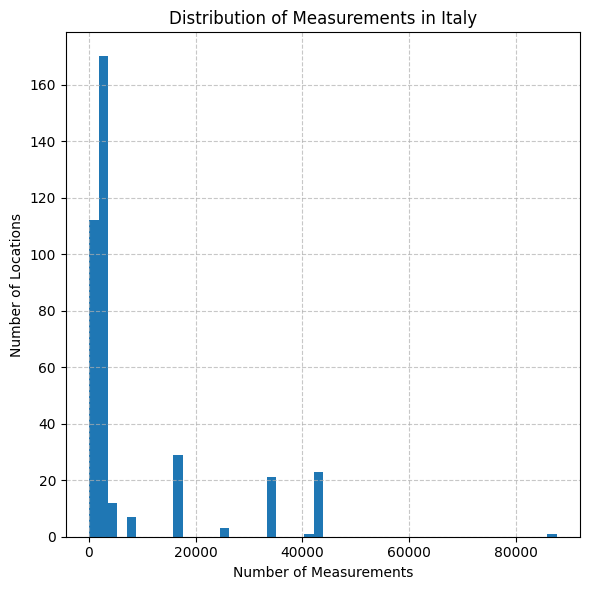

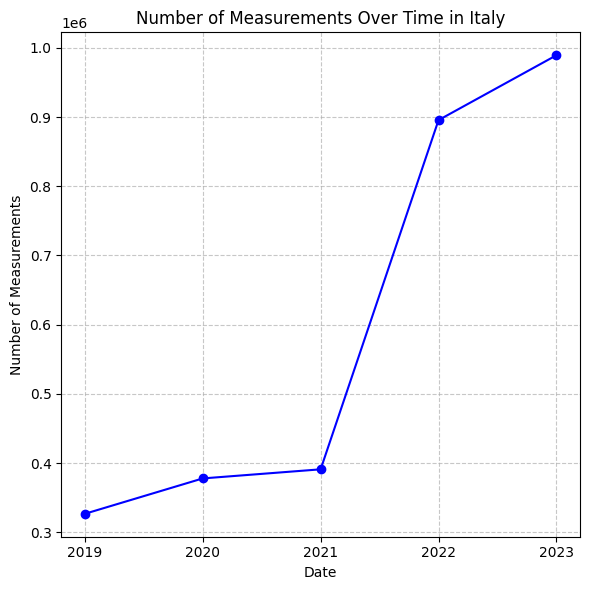

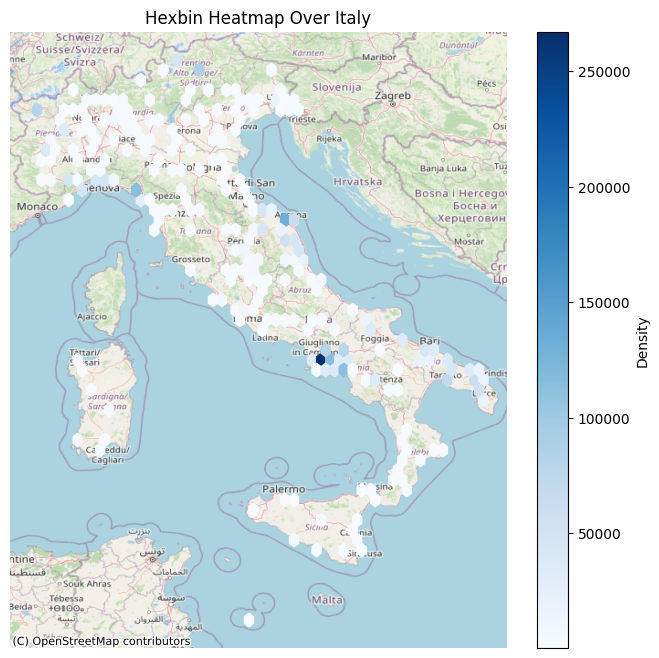

In [16]:
country_code, country_name = 'IT', 'Italy'
df = create_df(country_code, country_name, year=2019)
draw_misurements_distribution_histogram(df, country_name)
draw_misurements_by_year(df, country_name)
draw_heamap(df, country_name)

----

# POLAND

Reading data for Poland...
Data read.
--------------------
Parquet data:


,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Validity,Verification,ResultTime,DataCapture,FkObservationLog
2175,PL/SPO_PL0005R_6001_001,6001,2019-01-02,2019-01-03,2.82,ug.m-3,day,1,1,2020-08-21 21:27:21,NaN,0496a687-1a72-412b-966f-736f869bed12
2176,PL/SPO_PL0005R_6001_001,6001,2019-01-03,2019-01-04,2.84,ug.m-3,day,1,1,2020-08-21 21:27:21,NaN,0496a687-1a72-412b-966f-736f869bed12
2177,PL/SPO_PL0005R_6001_001,6001,2019-01-04,2019-01-05,8.75,ug.m-3,day,1,1,2020-08-21 21:27:21,NaN,0496a687-1a72-412b-966f-736f869bed12
2178,PL/SPO_PL0005R_6001_001,6001,2019-01-05,2019-01-06,3.49,ug.m-3,day,1,1,2020-08-21 21:27:21,NaN,0496a687-1a72-412b-966f-736f869bed12
2179,PL/SPO_PL0005R_6001_001,6001,2019-01-06,2019-01-07,7.69,ug.m-3,day,1,1,2020-08-21 21:27:21,NaN,0496a687-1a72-412b-966f-736f869bed12


--------------------
Metadata:


,Country,B-G Namespace,Year,Air Quality Network,Air Quality Network Name,Timezone,Air Quality Station EoI Code,Air Quality Station Nat Code,Air Quality Station Name,Sampling Point Id,...,Detection Limit,Detection Limit Unit,Documentation,QA Report,Duration,Duration Unit,Cadence,Cadence Unit,Source Data URL,Imported
62113,Poland,PL.CIEP.AQ,2024.0,NET_PL_DS_AQ,Dolnośląska Sieć Monitoringu Powietrza,UTC+01,PL0003R,DsSniezkaObs,Śnieżka,SPO_PL0003R_1_001,...,0.20,ug.m-3,QA/QC procedures,NaN,1,day,1,day,http://cdr.eionet.europa.eu/pl/eu/aqd/d/envz1b...,10/12/2024 13:00:25
62114,Poland,PL.CIEP.AQ,2024.0,NET_PL_DS_AQ,Dolnośląska Sieć Monitoringu Powietrza,UTC+01,PL0003R,DsSniezkaObs,Śnieżka,SPO_PL0003R_7_001,...,1.00,ug.m-3,QA/QC procedures,NaN,1,hour,1,hour,http://cdr.eionet.europa.eu/pl/eu/aqd/d/envz1b...,10/12/2024 13:00:25
62115,Poland,PL.CIEP.AQ,2024.0,NET_PL_DS_AQ,Dolnośląska Sieć Monitoringu Powietrza,UTC+01,PL0003R,DsSniezkaObs,Śnieżka,SPO_PL0003R_8_001,...,0.20,ug.m-3,QA/QC procedures,NaN,1,day,1,day,http://cdr.eionet.europa.eu/pl/eu/aqd/d/envz1b...,10/12/2024 13:00:25
62116,Poland,PL.CIEP.AQ,2024.0,NET_PL_DS_AQ,Dolnośląska Sieć Monitoringu Powietrza,UTC+01,PL0028A,DsCzerStraza,Czerniawa,SPO_PL0028A_1_001,...,0.59,ug.m-3,QA/QC procedures,NaN,1,hour,1,hour,http://cdr.eionet.europa.eu/pl/eu/aqd/d/envz1b...,10/12/2024 13:00:25
62117,Poland,PL.CIEP.AQ,2024.0,NET_PL_DS_AQ,Dolnośląska Sieć Monitoringu Powietrza,UTC+01,PL0028A,DsCzerStraza,Czerniawa,SPO_PL0028A_38_001,...,0.80,ug.m-3,QA/QC procedures,NaN,1,hour,1,hour,http://cdr.eionet.europa.eu/pl/eu/aqd/d/envz1b...,10/12/2024 13:00:25


--------------------
Data Range: 2019-01-01 01:00:00 to 2023-12-31 23:00:00
Total Number of Datapoints: 3596
Number of Unique Sampling Points: 226
Number of Unique Pollutants: 1
Number of sampling points without values: 0


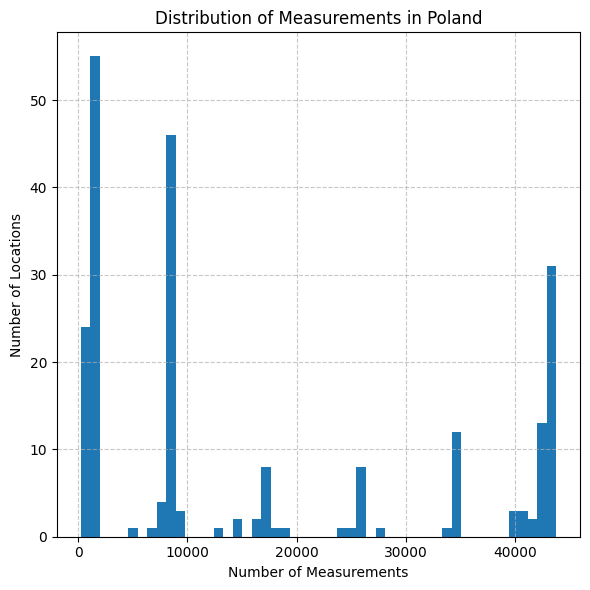

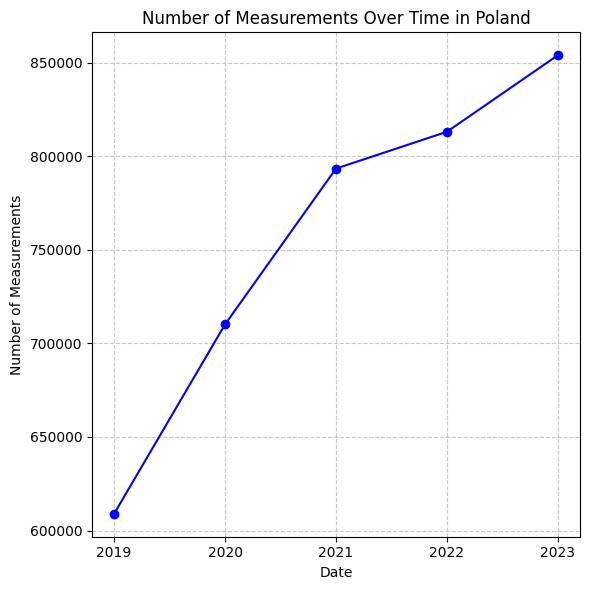

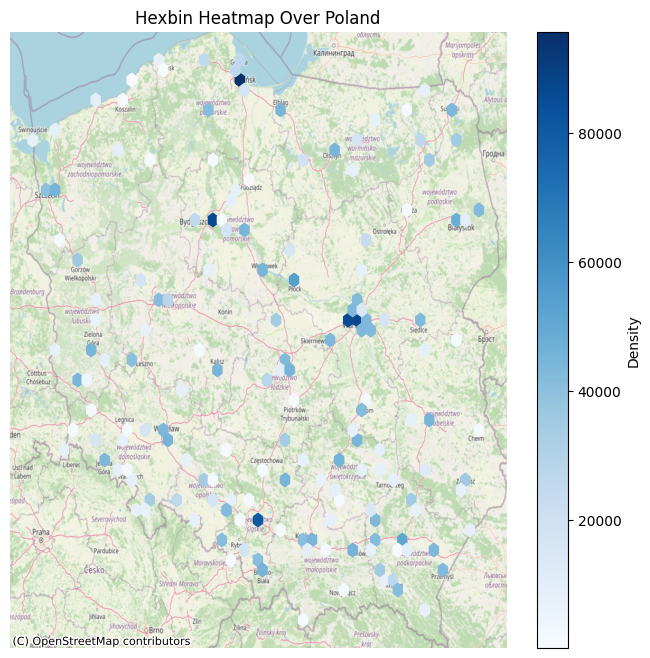

In [17]:
country_code, country_name = 'PL', 'Poland'
df = create_df(country_code, country_name, year=2019)
draw_misurements_distribution_histogram(df, country_name)
draw_misurements_by_year(df, country_name)
draw_heamap(df, country_name)

----

# SPAIN

Reading data for Spain...
Data read.
--------------------
Parquet data:


,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Validity,Verification,ResultTime,DataCapture,FkObservationLog
0,ES/SP_01036004_9_46,6001,2021-01-01 01:00:00,2021-01-01 02:00:00,4.0,ug.m-3,hour,1,1,2022-07-12 11:49:00,NaN,2ea4abc8-b8a3-4258-8fde-a8eee9b535b7
1,ES/SP_01036004_9_46,6001,2021-01-01 02:00:00,2021-01-01 03:00:00,2.0,ug.m-3,hour,1,1,2022-07-12 11:49:00,NaN,2ea4abc8-b8a3-4258-8fde-a8eee9b535b7
2,ES/SP_01036004_9_46,6001,2021-01-01 03:00:00,2021-01-01 04:00:00,0.0,ug.m-3,hour,1,1,2022-07-12 11:49:00,NaN,2ea4abc8-b8a3-4258-8fde-a8eee9b535b7
3,ES/SP_01036004_9_46,6001,2021-01-01 04:00:00,2021-01-01 05:00:00,1.0,ug.m-3,hour,1,1,2022-07-12 11:49:00,NaN,2ea4abc8-b8a3-4258-8fde-a8eee9b535b7
4,ES/SP_01036004_9_46,6001,2021-01-01 05:00:00,2021-01-01 06:00:00,1.0,ug.m-3,hour,1,1,2022-07-12 11:49:00,NaN,2ea4abc8-b8a3-4258-8fde-a8eee9b535b7


--------------------
Metadata:


,Country,B-G Namespace,Year,Air Quality Network,Air Quality Network Name,Timezone,Air Quality Station EoI Code,Air Quality Station Nat Code,Air Quality Station Name,Sampling Point Id,...,Detection Limit,Detection Limit Unit,Documentation,QA Report,Duration,Duration Unit,Cadence,Cadence Unit,Source Data URL,Imported
22360,Spain,ES.BDCA.AQD,2024.0,NET_ES021A,Ayto Zaragoza,UTC,ES1044A,50297026,EL PICARRAL,SP_50297026_10_49,...,-999.0,ug.m-3,NaN,http://missing.com,1,hour,1,hour,http://cdr.eionet.europa.eu/es/eu/aqd/d/envz2f...,18/12/2024 13:01:10
22361,Spain,ES.BDCA.AQD,2024.0,NET_ES021A,Ayto Zaragoza,UTC,ES1044A,50297026,EL PICARRAL,SP_50297026_10_M,...,10000.0,ug.m-3,15%,http://missing.com,1,day,1,day,http://cdr.eionet.europa.eu/es/eu/aqd/d/envz2f...,18/12/2024 13:01:10
22362,Spain,ES.BDCA.AQD,2024.0,NET_ES021A,Ayto Zaragoza,UTC,ES1044A,50297026,EL PICARRAL,SP_50297026_12_8,...,0.4,ug.m-3,NaN,NaN,1,hour,1,hour,http://cdr.eionet.europa.eu/es/eu/aqd/d/envz2f...,18/12/2024 13:01:10
22363,Spain,ES.BDCA.AQD,2024.0,NET_ES021A,Ayto Zaragoza,UTC,ES1044A,50297026,EL PICARRAL,SP_50297026_14_6,...,1.0,ug.m-3,"PARA 200PPB +/- 6,6",NaN,1,hour,1,hour,http://cdr.eionet.europa.eu/es/eu/aqd/d/envz2f...,18/12/2024 13:01:10
22364,Spain,ES.BDCA.AQD,2024.0,NET_ES021A,Ayto Zaragoza,UTC,ES1044A,50297026,EL PICARRAL,SP_50297026_17_M,...,50.0,ng.m-3,20%,http://missing.com,1,day,1,day,http://cdr.eionet.europa.eu/es/eu/aqd/d/envz2f...,18/12/2024 13:01:10


--------------------
Data Range: 2019-01-01 01:00:00 to 2024-01-01 00:00:00
Total Number of Datapoints: 9625
Number of Unique Sampling Points: 361
Number of Unique Pollutants: 1
Number of sampling points without values: 0


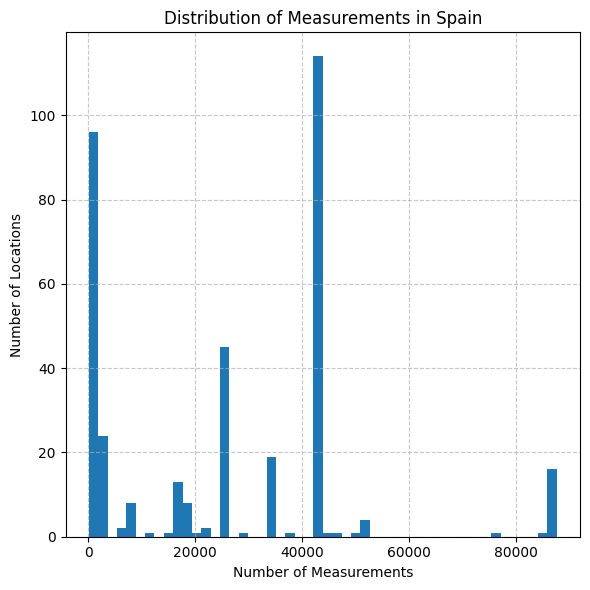

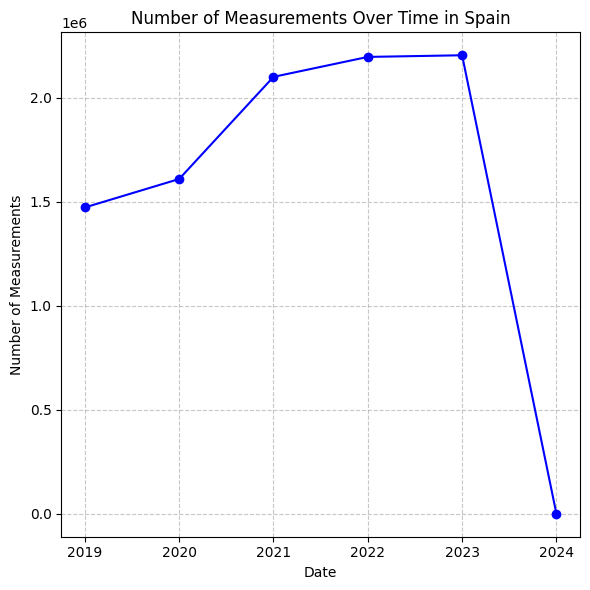

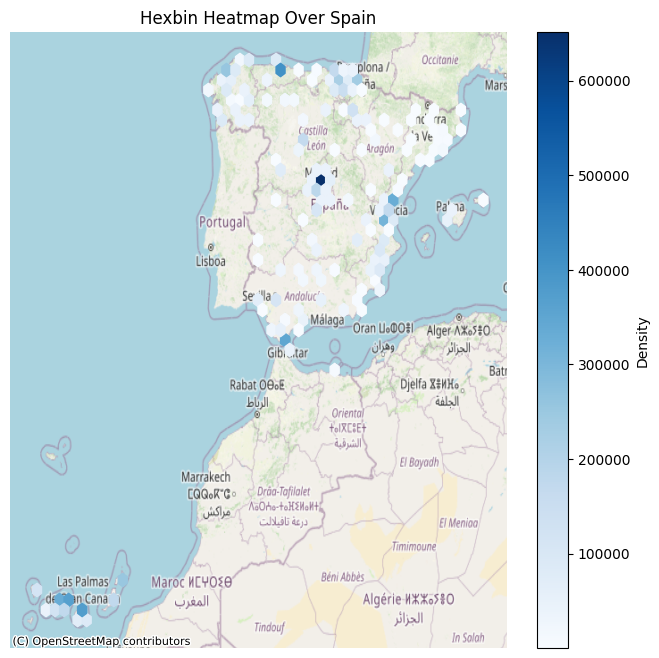

In [8]:
country_code, country_name = 'ES', 'Spain'
df = create_df(country_code, country_name, year=2019)
draw_misurements_distribution_histogram(df, country_name)
draw_misurements_by_year(df, country_name)
draw_heamap(df, country_name)

----

# Finland

Reading data for Finland...
Data read.
--------------------
Parquet data:


,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Validity,Verification,ResultTime,DataCapture,FkObservationLog
0,FI/SPO-FI00027_06001_100,6001,2021-12-31 23:00:00,2022-01-01 00:00:00,17.6,ug.m-3,hour,1,1,2023-08-03 11:07:25,NaN,8107c00f-e6fd-48d9-b437-7d5639262f93
1,FI/SPO-FI00027_06001_100,6001,2022-01-01 00:00:00,2022-01-01 01:00:00,8.2,ug.m-3,hour,1,1,2023-08-03 11:07:25,NaN,8107c00f-e6fd-48d9-b437-7d5639262f93
2,FI/SPO-FI00027_06001_100,6001,2022-01-01 01:00:00,2022-01-01 02:00:00,4.4,ug.m-3,hour,1,1,2023-08-03 11:07:25,NaN,8107c00f-e6fd-48d9-b437-7d5639262f93
3,FI/SPO-FI00027_06001_100,6001,2022-01-01 02:00:00,2022-01-01 03:00:00,4.1,ug.m-3,hour,1,1,2023-08-03 11:07:25,NaN,8107c00f-e6fd-48d9-b437-7d5639262f93
4,FI/SPO-FI00027_06001_100,6001,2022-01-01 03:00:00,2022-01-01 04:00:00,3.8,ug.m-3,hour,1,1,2023-08-03 11:07:25,NaN,8107c00f-e6fd-48d9-b437-7d5639262f93


--------------------
Metadata:


,Country,B-G Namespace,Year,Air Quality Network,Air Quality Network Name,Timezone,Air Quality Station EoI Code,Air Quality Station Nat Code,Air Quality Station Name,Sampling Point Id,...,Detection Limit,Detection Limit Unit,Documentation,QA Report,Duration,Duration Unit,Cadence,Cadence Unit,Source Data URL,Imported
31985,Finland,FI.FMI.AQ,2023.0,NET-FI001A,Raahen verkko,UTC+02,FI00359,359,Lapaluoto,SPO-FI00359_00001_100,...,-999.0,ug.m-3,NaN,https://raahe.fi/sites/raahe.fi/files/liitetie...,1,hour,1,hour,http://cdr.eionet.europa.eu/fi/eu/aqd/d/envztg...,05/09/2024 01:37:54
31986,Finland,FI.FMI.AQ,2023.0,NET-FI001A,Raahen verkko,UTC+02,FI00359,359,Lapaluoto,SPO-FI00359_00001_100,...,-999.0,ug.m-3,NaN,https://raahe.fi/sites/raahe.fi/files/liitetie...,1,hour,1,hour,http://cdr.eionet.europa.eu/fi/eu/aqd/d/envztg...,05/09/2024 01:37:54
31987,Finland,FI.FMI.AQ,2023.0,NET-FI001A,Raahen verkko,UTC+02,FI00359,359,Lapaluoto,SPO-FI00359_05012_100,...,-999.0,ng.m-3,NaN,NaN,1,day,31,day,http://cdr.eionet.europa.eu/fi/eu/aqd/d/envztg...,05/09/2024 01:37:54
31988,Finland,FI.FMI.AQ,2023.0,NET-FI001A,Raahen verkko,UTC+02,FI00359,359,Lapaluoto,SPO-FI00359_05012_100,...,-999.0,ng.m-3,NaN,NaN,1,day,1,day,http://cdr.eionet.europa.eu/fi/eu/aqd/d/envztg...,05/09/2024 01:37:54
31989,Finland,FI.FMI.AQ,2023.0,NET-FI001A,Raahen verkko,UTC+02,FI00359,359,Lapaluoto,SPO-FI00359_05012_100,...,0.3,ng.m-3,NaN,https://raahe.fi/sites/raahe.fi/files/liitetie...,1,variable,1,variable,http://cdr.eionet.europa.eu/fi/eu/aqd/d/envztg...,05/09/2024 01:37:54


--------------------
Data Range: 2019-01-01 01:00:00 to 2023-12-31 22:00:00
Total Number of Datapoints: 1344
Number of Unique Sampling Points: 26
Number of Unique Pollutants: 1
Number of sampling points without values: 0


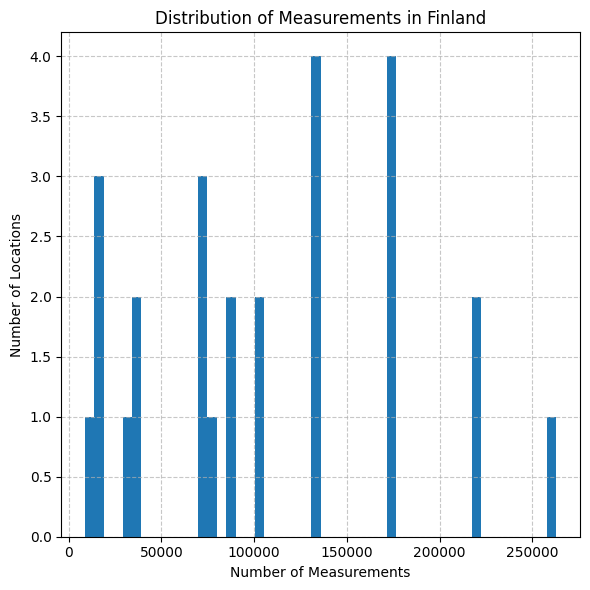

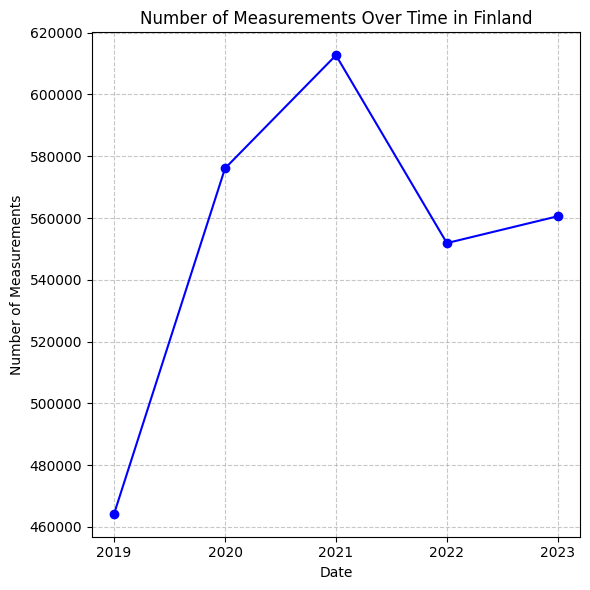

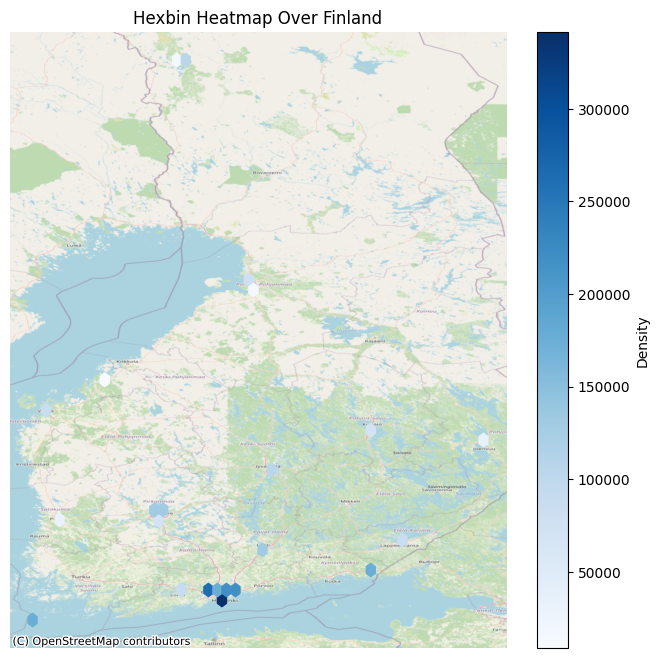

In [19]:
country_code, country_name = 'FI', 'Finland'
df = create_df(country_code, country_name, year=2019)
draw_misurements_distribution_histogram(df, country_name)
draw_misurements_by_year(df, country_name)
draw_heamap(df, country_name)